# Try artificial neural netwroks on the bulk RNA-seq data (disclaimer: there is still room to improve this notebook)
We decided to train NN models on the TF affinity binding scores (features) predicting the single cell gene expression (responses) hoping that this change of approach (from linear to non-linear) would improve the single cell gene expression prediction. [The results](https://github.com/fba67/scMTL/blob/master/sc_NN.ipynb), however, pointed to a significant amount of noise in the data based on the tremendous over-fitting the models exhibited. Therefore, we decided to change the response from single cell to bulk as a way of erradicating the effect of noise on our analysis (at least from the response point of view). The feature to response correlation [analysis](https://github.com/fba67/scMTL/blob/master/feature2response_correlation_analysis.ipynb) already had shown a very negligble correlation value, but we still will try NN on the bulk data jsut to be sure. This analysis showed that the best correlation is obtained when CEL_R2_HLC samples are used. **Therefore, we use only CEL_R2_HLC as the response variable.**

## Load the required libraries

In [1]:
library(keras)
library(ggplot2)
library(pheatmap)

## Load the partitioned and normalized data (to save I/O operations)

In [2]:
load("../Stem_Net_MinMaxNormalized_data.RData")

### List of variables in the workspace after loading the data file

In [3]:
print(ls())

[1] "test_x"  "test_y"  "train_x" "train_y" "x"       "y"      


Here we ignore the y, test_y, and train_Y variables as they represent the single cell expression data stored in the RData file. We should instead replace these values with the corresponding bulk expression data.

### Dimensions of the training and test data

In [4]:
print("train:")
print(dim(train_x))

print("test:")
print(dim(test_x))

[1] "train:"
[1] 11396   726
[1] "test:"
[1] 2850  726


In [5]:
print(range(train_x))
print(range(train_y))

[1] 0 1
[1] 0 1


## Read the bulk expression data

In [6]:
bulk.rna <- read.table("/MMCI/MS/ExpRegulation/work/data/singleCell/iPCs_Kathrin/bulkRNAseq_TPM.txt")

## Subset the bulk RNA data according to the genes split into training and test set

In [7]:
## Find the corresponding indices
training.hits <- which(rownames(bulk.rna) %in% rownames(train_x))
test.hits <- which(rownames(bulk.rna) %in% rownames(test_x))

print(length(training.hits))
print(length(test.hits))

[1] 11396
[1] 2850


In [8]:
## Perform subsetting
train_y <- bulk.rna[training.hits, 2] # 2 for selecting CEL_R2_HLC
test_y <- bulk.rna[test.hits, 2] # 2 for selecting CEL_R2_HLC

print(length(train_y))
print(length(test_y))

[1] 11396
[1] 2850


## Log-transform and normalize the bulk RNA data

In [9]:
# Log-transform
train_y <- log2(1 + train_y)
test_y <- log2(1 + test_y)

doMinMax <- T
# Normalize the response
if(!doMinMax){
    train_y <- scale(train_y)

    col_means_train <- attr(train_y, "scaled:center") 
    col_stddevs_train <- attr(train_y, "scaled:scale")
    test_y <- scale(test_y, center = col_means_train, scale = col_stddevs_train)
}else{
    mn <- min(train_y)
    mx <- max(train_y)
    train_y <- (train_y - mn) / (mx - mn)
    test_y <- (test_y - mn) / (mx - mn)
}

In [10]:
print(range(train_y))
print(range(test_y))

[1] 0 1
[1] 0.0000000 0.9187957


## Investigate distributions between training and test feature data
Here I decided to use the Kolmogrov-Smirnov test instead of the PCA components to reassure similarities between the training and test samples.

In [11]:
options(warn = -1) # To avoid the warning prompts referring to the presence of ties
ks.res <- sapply(seq(ncol(train_x)), function(i) ks.test(train_x[, i], test_x[, i]))
q.values <- p.adjust(ks.res[2, ], method= "BH")
colnames(train_x[which(q.values <= .05)])

character(0)

The results above show that multiple-test corrected p-values are all **larger than 0.05**, hinting to the **similarity** of distributions between training and test partitions.

## Set the NN hyper-parameters

In [12]:
epochs <- 200
early_stop_patience <- 20
hidden_layer <- 50 #c(floor(mean(ncol(train_x), ncol(train_y))))
#hidden_layer <- c(512, 256, 128)
print("hiddenlayer info:")
print(hidden_layer)
activation_func <- c("tanh")#, "tanh", "tanh")
drop_out_rate <- .01
batch_size <- 16
val_split_ratio <- .1
l1_lambda <- l2_lambda <- .0

[1] "hiddenlayer info:"
[1] 50


## Build the NN model

In [13]:
model <- keras_model_sequential()

# build the 1st layer
layer_dense(model, units= hidden_layer[1], activation= activation_func[1], input_shape= ncol(train_x),
            kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
model <- layer_dropout(model, rate= drop_out_rate)

# add the other hidden layers
if(length(hidden_layer) > 1){
    for(i in seq(2, length(hidden_layer))){
        model <- layer_dense(model, units= hidden_layer[i], activation= activation_func[i],
                          kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
        model <- layer_dropout(model, rate= drop_out_rate)
    }
}

# finish off by adding the output layer
model <- layer_dense(model, units= 1, activation = "tanh")

## Compile the model

In [14]:
compile(model, loss= "mse", optimizer= optimizer_rmsprop(), metrics= list("mean_absolute_error"))

## Summary of the model

In [15]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 50)                      36350       
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       51          
Total params: 36,401
Trainable params: 36,401
Non-trainable params: 0
________________________________________________________________________________


## Fit the data to the built and compiled model
Since there are various replicates for the bulk RNA-seq data, we train a separate NN model for each.

In [16]:
early_stop <- callback_early_stopping(monitor= "val_loss", patience= early_stop_patience)

history <- fit(model, as.matrix(train_x), train_y, 
               epochs= epochs, batch_size= batch_size, validation_split= val_split_ratio,
               verbose= 1, callback= list(early_stop))


## Model performance per epoch

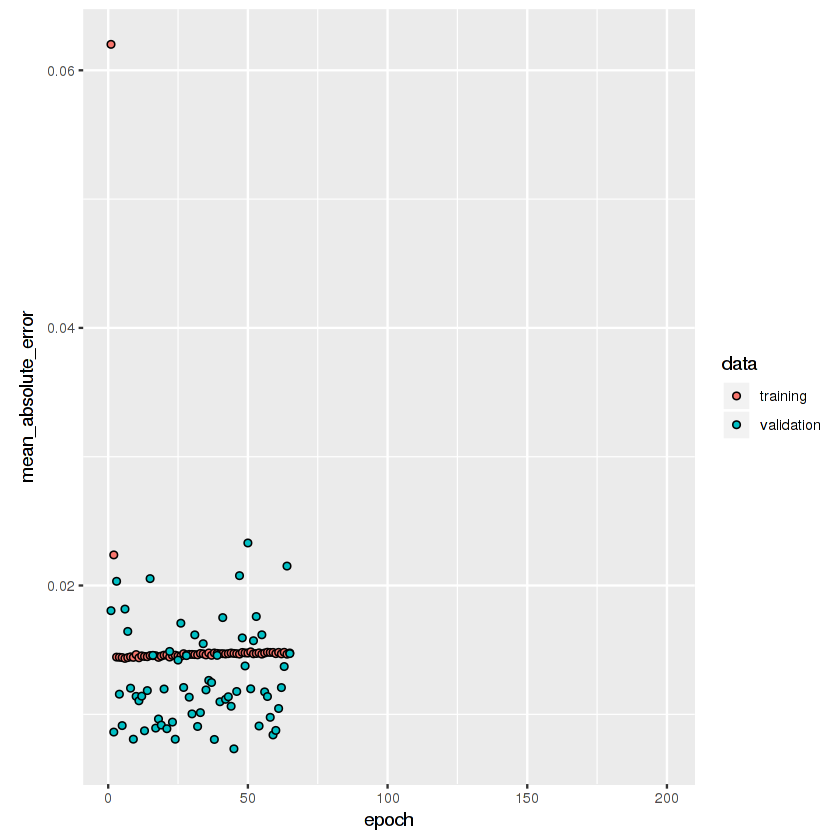

In [17]:
print(plot(history, metrics = "mean_absolute_error", smooth = FALSE))

## Predict the response

In [18]:
pred.train <- predict(model, as.matrix(train_x))
pred.test <- predict(model, as.matrix(test_x))

## Plot the response (perdicted and measured) on the training data

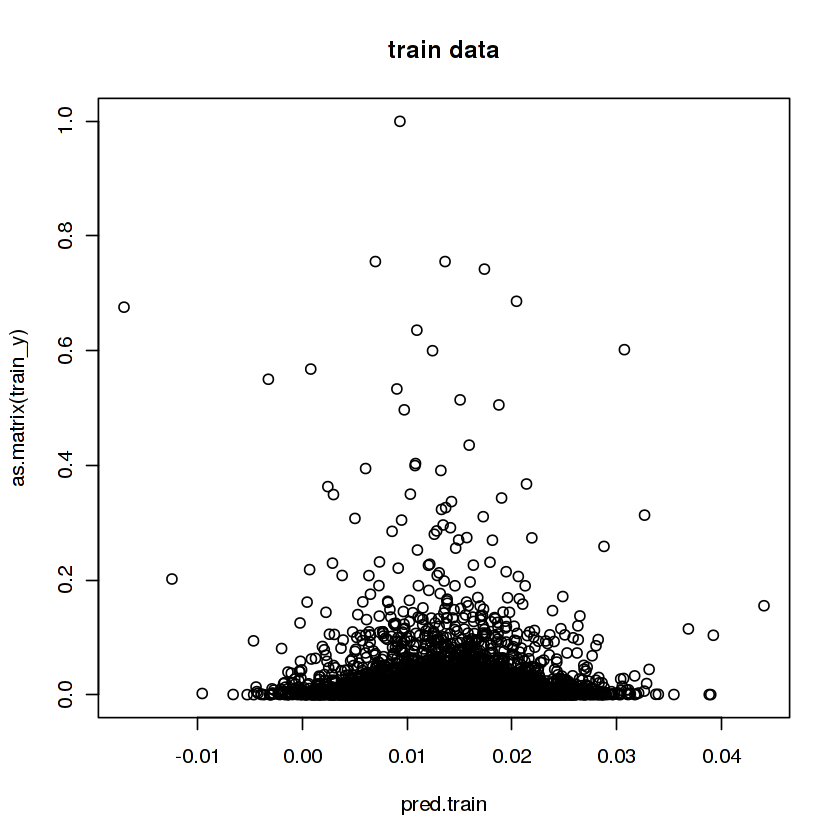

In [19]:
plot(pred.train, as.matrix(train_y), main= "train data")

## Plot the response (perdicted and measured) on the test data

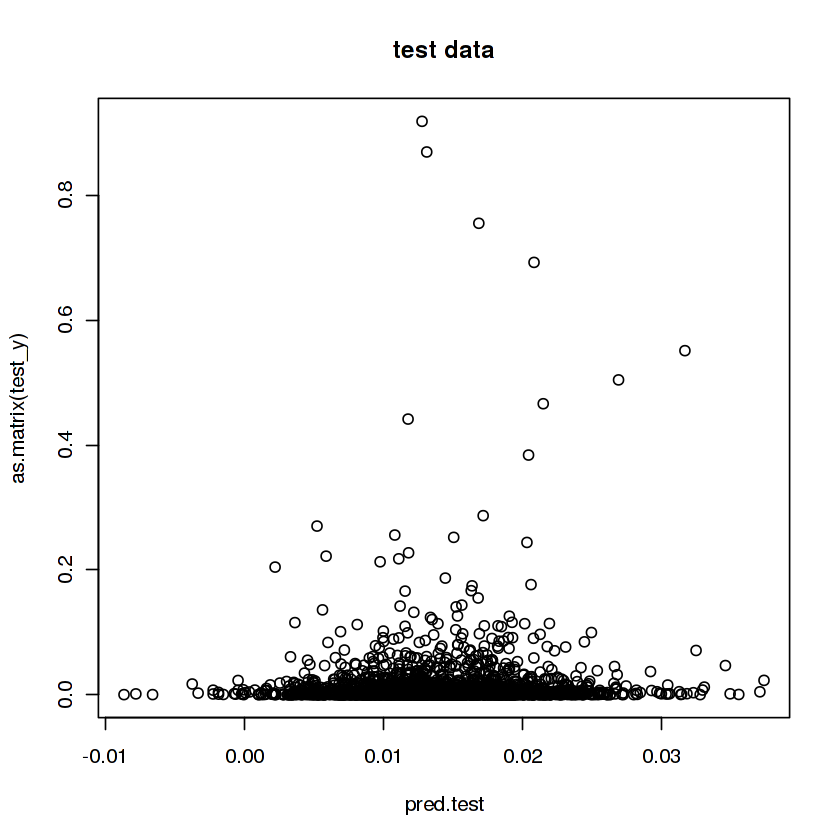

In [20]:
plot(pred.test, as.matrix(test_y), main= "test data")

## Compute the correlation between the actual response and the predicted

In [21]:
cors.train <- sapply(seq(ncol(pred.train)), function(i) cor(pred.train[, i], train_y))
cors.test <- sapply(seq(ncol(pred.test)), function(i) cor(pred.test[, i], test_y))

## Plot the correlation histograms

[1] -0.02654438 -0.02654438


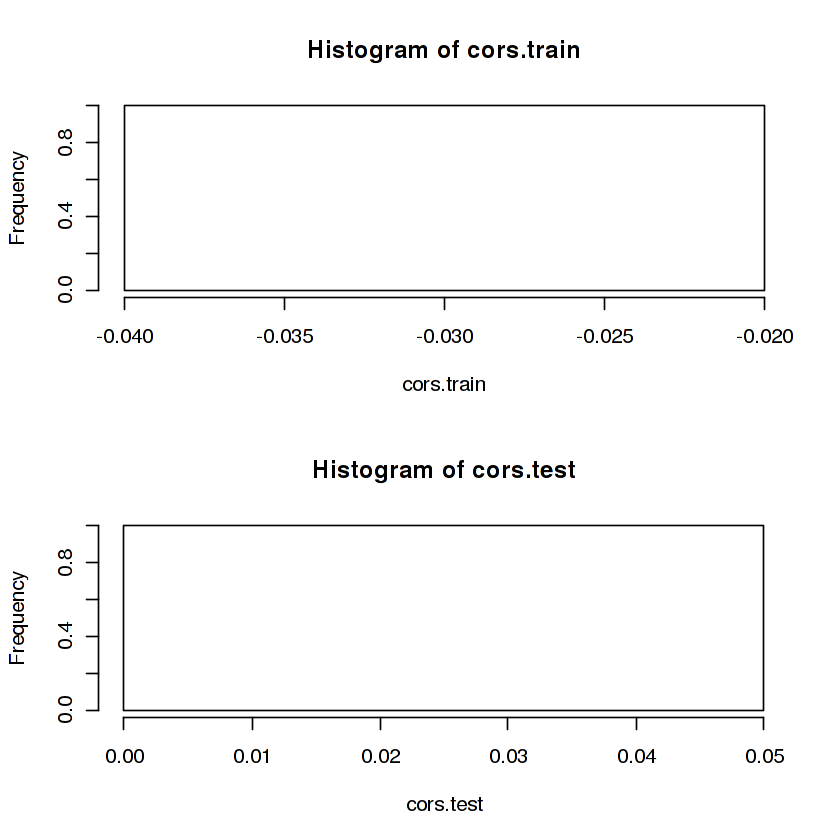

In [22]:
print(range(cors.train))
par(mfrow= c(2, 1))
hist(cors.train)
hist(cors.test)

## Get model weights

In [23]:
model_weights <- get_weights(model)
print(length(model_weights))

[1] 4


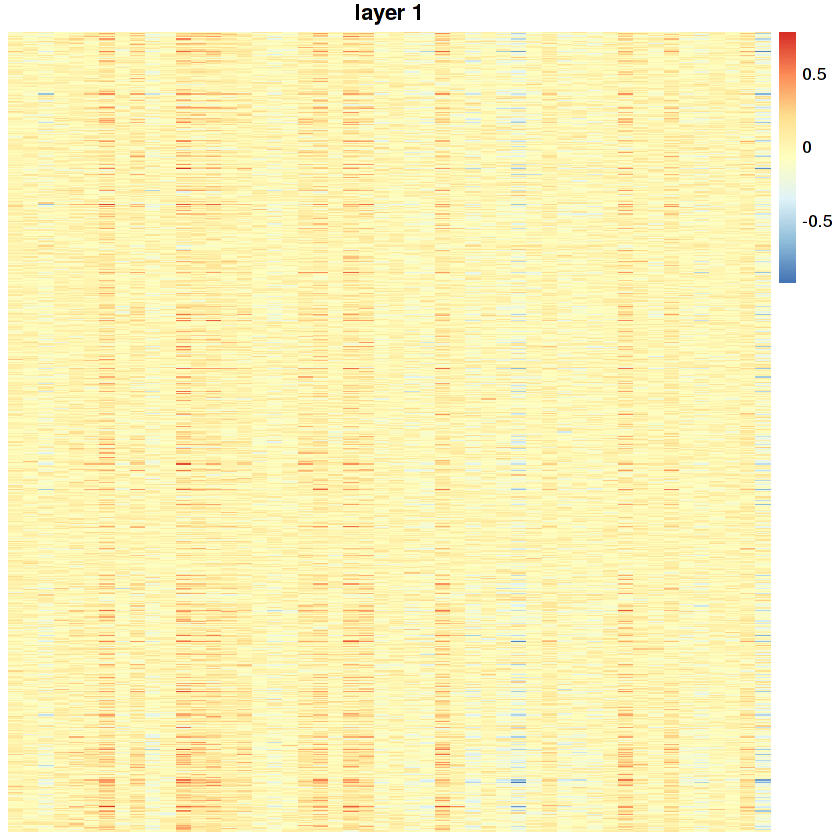

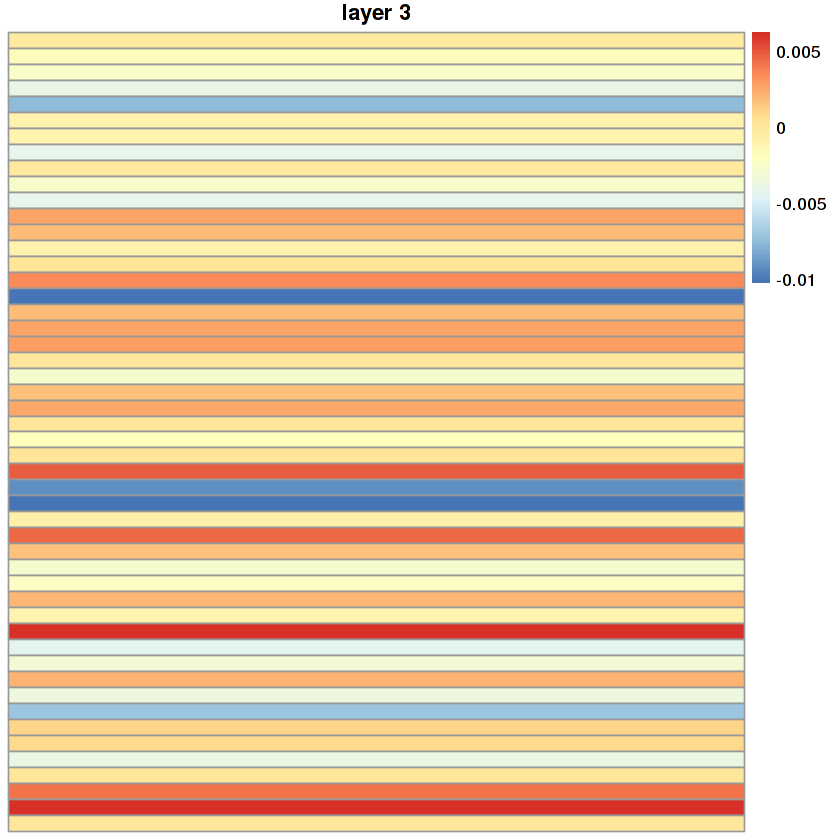

In [24]:
for(i in seq(1, length(model_weights), by= 2)) # Skipping the bias weights
    pheatmap(model_weights[[i]], cluster_rows= F, cluster_cols= F, main= paste("layer", i))

# Conclusion

* I doubted the type of normalization used, so I changed it from unit variance and zero-mean (data not shown) to the min-max normalization. It had noinfluence on the results
* I changed the output layer's activation function from relu to tanh (given the change in the normalization method) and that slightly improve the results from having correlation of absolutly zero to something slightly more
* The scatter plot showing the prediction on the test data is still quite absurd